In [1]:
import numpy as np
import pycbc.conversions as pc
import pycbc.pnutils as pnu
import pandas as pd
import h5py, os

from collections import defaultdict

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import random

import sys
from lal import YRJUL_SI

import seaborn as sns

import ast

In [2]:
def save_dict_to_hdf5(dic, filename):
    """
    ....
    """
    with h5py.File(filename, 'w') as h5file:
        recursively_save_dict_contents_to_group(h5file, '/', dic)

def recursively_save_dict_contents_to_group(h5file, path, dic):
    """
    ....
    """
    for key, item in dic.items():
        if isinstance(item, (np.ndarray, np.int64, np.float64, str, bytes)):
            h5file[path + key] = item
        elif isinstance(item, dict):
            recursively_save_dict_contents_to_group(h5file, path + key + '/', item)
        else:
            raise ValueError('Cannot save %s type'%type(item))

def load_dict_from_hdf5(filename):
    """
    ....
    """
    with h5py.File(filename, 'r') as h5file:
        return recursively_load_dict_contents_from_group(h5file, '/')

def recursively_load_dict_contents_from_group(h5file, path):
    """
    ....
    """
    ans = {}
    for key, item in h5file[path].items():
        if isinstance(item, h5py._hl.dataset.Dataset):
            ans[key] = item[()]
        elif isinstance(item, h5py._hl.group.Group):
            ans[key] = recursively_load_dict_contents_from_group(h5file, path + key + '/')
            
    return ans


def print_some_rcParams():
    rc_keys = ['backend', 'axes.labelsize', 'axes.titlesize', 'font.size',
        'legend.fontsize', 'xtick.labelsize', 'ytick.labelsize', 'font.family',
        'text.usetex', 'figure.figsize'] # 'font.sans-serif', 'font.serif'
    print('Using the following matplotlib settings:')
    for k in rc_keys:
        print(k, ':', plt.rcParams[k])

In [3]:
ifar_threshold = 10 ## yr 
number_injection = 10

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_columns', None)

In [5]:
#This is the first file, all events are true
injection_file = '/home/bhooshan.gadre/work/O3/sub_solar_search/O3B_VTs/ssm-search/O3b_VTs/common_ssm_injections.hdf'
injections = load_dict_from_hdf5(injection_file)
injections.keys(), len(injections.keys())

(dict_keys(['coa_phase', 'declination', 'distance', 'gstlal_ifar', 'gstlal_weight', 'inclination', 'mass1_source', 'mass2_source', 'mbta_ifar', 'polarization', 'pycbc_ifar', 'right_ascension', 'snr_H', 'snr_L', 'snr_V', 'spin1x', 'spin1y', 'spin1z', 'spin2x', 'spin2y', 'spin2z', 'time']),
 22)

In [6]:
df_true = pd.DataFrame(injections)
df_true

,coa_phase,declination,distance,gstlal_ifar,gstlal_weight,inclination,mass1_source,mass2_source,mbta_ifar,polarization,pycbc_ifar,right_ascension,snr_H,snr_L,snr_V,spin1x,spin1y,spin1z,spin2x,spin2y,spin2z,time
0,1.463821,-1.232698,231.483117,0.0,0.666667,2.867627,1.692460,0.501600,0.0,2.515262,0.0,0.164688,2.440571,2.957571,1.361124,0.053696,0.053141,-0.037187,0.057080,-0.011039,0.007150,1.238166e+09
1,0.673478,-0.622410,458.599031,0.0,1.000000,0.918732,6.421466,0.763863,0.0,0.135494,0.0,2.177941,2.684150,2.988815,1.259368,-0.025080,-0.011637,0.021298,0.020269,0.071086,0.038439,1.238166e+09
2,5.447231,-1.440067,302.357273,0.0,0.666667,0.854144,10.481894,1.045793,0.0,0.132165,0.0,2.621765,4.408046,6.731172,1.315282,-0.004171,-0.046270,0.012784,0.021928,-0.027524,-0.030501,1.238166e+09
3,5.521864,-1.276307,463.341251,0.0,0.666667,0.494481,8.906005,0.811978,0.0,1.828451,0.0,3.177169,2.049177,3.539541,0.762279,0.000633,0.001265,-0.000504,0.004547,-0.011592,-0.004068,1.238166e+09
4,0.183151,-0.734805,833.927353,0.0,1.000000,2.895566,7.129897,0.808812,0.0,2.805147,0.0,2.219308,2.389652,3.215351,0.549881,-0.051269,0.011986,-0.001127,-0.021172,0.014852,-0.003302,1.238166e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1916578,0.187059,-0.469964,752.284246,0.0,1.000000,0.388063,5.784159,0.559250,0.0,3.122078,0.0,4.757083,2.959844,2.958614,0.812961,-0.032232,0.036856,-0.038265,-0.001476,0.035159,-0.032295,1.269562e+09
1916579,0.141624,-0.272180,643.259480,0.0,0.666667,3.032152,8.621294,0.868851,0.0,0.817515,0.0,1.586071,2.718237,3.586084,3.759479,-0.007036,-0.019932,0.032837,-0.038478,0.020862,-0.010397,1.269562e+09
1916580,1.174031,-0.227858,349.130344,0.0,0.666667,2.206089,10.560706,0.717379,0.0,1.318691,0.0,3.475683,3.402718,2.469075,1.012893,0.004500,-0.054032,-0.029833,0.062644,0.023295,-0.031378,1.269562e+09
1916581,5.752044,0.708430,455.222188,0.0,1.000000,2.115026,5.727628,0.886952,0.0,1.553802,0.0,2.464774,2.854940,3.862371,0.634093,-0.028952,-0.016063,-0.024699,-0.048624,-0.022375,0.007844,1.269562e+09


In [7]:
df_true = df_true.drop(columns=['coa_phase', 'declination', 'distance', 'gstlal_ifar', 'gstlal_weight', 'inclination', 'mbta_ifar', 'polarization', 
                                'right_ascension', 'snr_H', 'snr_L', 'snr_V', 'spin1x', 'spin1y', 'spin2x', 'spin2y', 'time'])

df_true['label'] = 1

df_true = df_true.rename(columns={'mass2_source': 'mass2', 
                                  'mass1_source': 'mass1'})

df_true

,mass1,mass2,pycbc_ifar,spin1z,spin2z,label
0,1.692460,0.501600,0.0,-0.037187,0.007150,1
1,6.421466,0.763863,0.0,0.021298,0.038439,1
2,10.481894,1.045793,0.0,0.012784,-0.030501,1
3,8.906005,0.811978,0.0,-0.000504,-0.004068,1
4,7.129897,0.808812,0.0,-0.001127,-0.003302,1
...,...,...,...,...,...,...
1916578,5.784159,0.559250,0.0,-0.038265,-0.032295,1
1916579,8.621294,0.868851,0.0,0.032837,-0.010397,1
1916580,10.560706,0.717379,0.0,-0.029833,-0.031378,1
1916581,5.727628,0.886952,0.0,-0.024699,0.007844,1


In [8]:
#this the background
trig_file = "/home/pycbc.offline/O3/production/O3A_SUB_SOLAR/sub_solar/STATMAP/H1L1V1-COMBINE_STATMAP_FULL_DATA-1238787802-853441.hdf"
bank_file = "/home/pycbc.offline/O3/production/O3A_SUB_SOLAR/sub_solar/BANK/H1L1V1-BANK2HDF-1238787802-853441.hdf"

In [9]:
%%time
bank = h5py.File(bank_file, 'r')
hashes = bank['template_hash'][:]

bank_tids = hashes.argsort()
fields = ['mass1', 'mass2', 'spin1z', 'spin2z']
trigs = h5py.File(trig_file, 'r')

trig_params = defaultdict(list)
for tid in trigs['background']['template_id'][:number_injection]:  ## test with 10 triggers. Later this can be [:] for all triggers
    bank_idx = np.argwhere(bank_tids == tid)[0]
    for k in fields:
        trig_params[k].append(bank[k][:][bank_idx][0])
#print(trig_params)

CPU times: user 298 ms, sys: 200 ms, total: 498 ms
Wall time: 548 ms


In [10]:
print(trig_params)

defaultdict(<class 'list'>, {'mass1': [0.5049287468690198, 1.4890962096222466, 0.5584945606105989, 0.30992199092256534, 0.20621452536587256, 6.0120204674999655, 0.9745523320171033, 0.5214335060019926, 0.5423446824343688, 1.0842931303911676], 'mass2': [0.21458005221417903, 0.21205771715862032, 0.2044448030937099, 0.2008728164584661, 0.20621452536587256, 0.7340735619694843, 0.2556743567108287, 0.20865151534506626, 0.20605241989917558, 0.27170560413115535], 'spin1z': [-0.6862350742339347, -0.7286678705958807, 0.7745876481316094, -0.09982390851178215, 0.09989187095218796, 0.8999412988935003, 0.4513576754964428, 0.6390865474789664, -0.7355112205159183, -0.5541470127492194], 'spin2z': [-0.056092396754344645, 0.024225545145718428, 0.006712229612723681, -0.07828719811217069, 0.09990277072233664, 0.41893731416659385, -0.08913105732121088, 0.08529964032606609, 0.010133644484569012, 0.022674100783847937]})


In [11]:
len(trigs['background']['template_id'])

39955275

In [12]:
len(trigs['background_h0']['H1L1']['ifar'])

16322600

In [13]:
len(trigs['background_h0']['H1L1V1']['ifar'][:])

127274

In [14]:
trigs['background_h0']['H1L1V1']['ifar'][:10]

array([1.83540772, 0.02920396, 4.81109905, 0.03547405, 0.07905803,
       2.01532598, 0.00685824, 0.51929064, 0.03567827, 0.38252941])

In [15]:
background_file = '/home/lucashernan.quiceno/background/output.txt'

with open(background_file, 'r') as file:
    content = file.read()

# Convert the contents of the file into a Python dictionary
data_dict = ast.literal_eval(content.replace("defaultdict(<class 'list'>, ", "").rstrip(')'))

# Convert the dictionary to a DataFrame
df_false = pd.DataFrame(data_dict)

df_false

,mass1,mass2,spin1z,spin2z
0,0.504929,0.214580,-0.686235,-0.056092
1,1.489096,0.212058,-0.728668,0.024226
2,0.558495,0.204445,0.774588,0.006712
3,0.309922,0.200873,-0.099824,-0.078287
4,0.206215,0.206215,0.099892,0.099903
...,...,...,...,...
1916578,0.864843,0.247605,-0.416889,0.025385
1916579,0.501223,0.202115,-0.743296,-0.011618
1916580,0.956881,0.213006,-0.813010,0.049815
1916581,0.808391,0.312963,-0.449955,-0.030445


In [16]:
#df_false = pd.DataFrame(trig_params)

df_false['pycbc_ifar'] = trigs['background_h0']['H1L1']['ifar'][:1916583]

df_false['label'] = 0
df_false

,mass1,mass2,spin1z,spin2z,pycbc_ifar,label
0,0.504929,0.214580,-0.686235,-0.056092,0.000314,0
1,1.489096,0.212058,-0.728668,0.024226,0.000070,0
2,0.558495,0.204445,0.774588,0.006712,0.000018,0
3,0.309922,0.200873,-0.099824,-0.078287,0.000821,0
4,0.206215,0.206215,0.099892,0.099903,0.000288,0
...,...,...,...,...,...,...
1916578,0.864843,0.247605,-0.416889,0.025385,0.000010,0
1916579,0.501223,0.202115,-0.743296,-0.011618,0.000011,0
1916580,0.956881,0.213006,-0.813010,0.049815,0.000470,0
1916581,0.808391,0.312963,-0.449955,-0.030445,0.000045,0


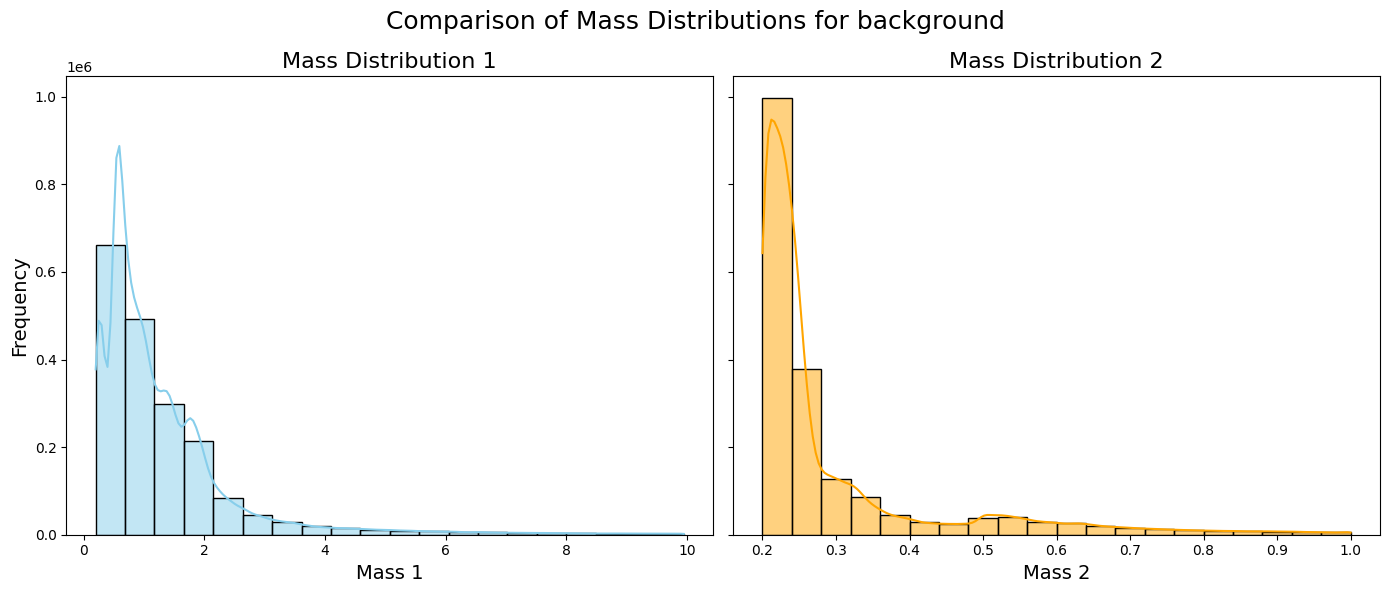

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Plot of the distribution of 'mass1'
sns.histplot(df_false['mass1'], bins=20, kde=True, color='skyblue', ax=axs[0])
axs[0].set_xlabel('Mass 1', fontsize=14)
axs[0].set_ylabel('Frequency', fontsize=14)
axs[0].set_title('Mass Distribution 1', fontsize=16)

# Plot of the distribution of 'mass2'
sns.histplot(df_false['mass2'], bins=20, kde=True, color='orange', ax=axs[1])
axs[1].set_xlabel('Mass 2', fontsize=14)
axs[1].set_title('Mass Distribution 2', fontsize=16)

fig.suptitle('Comparison of Mass Distributions for background', fontsize=18)

# Adjust the layout and display the chart
plt.tight_layout()
plt.show()

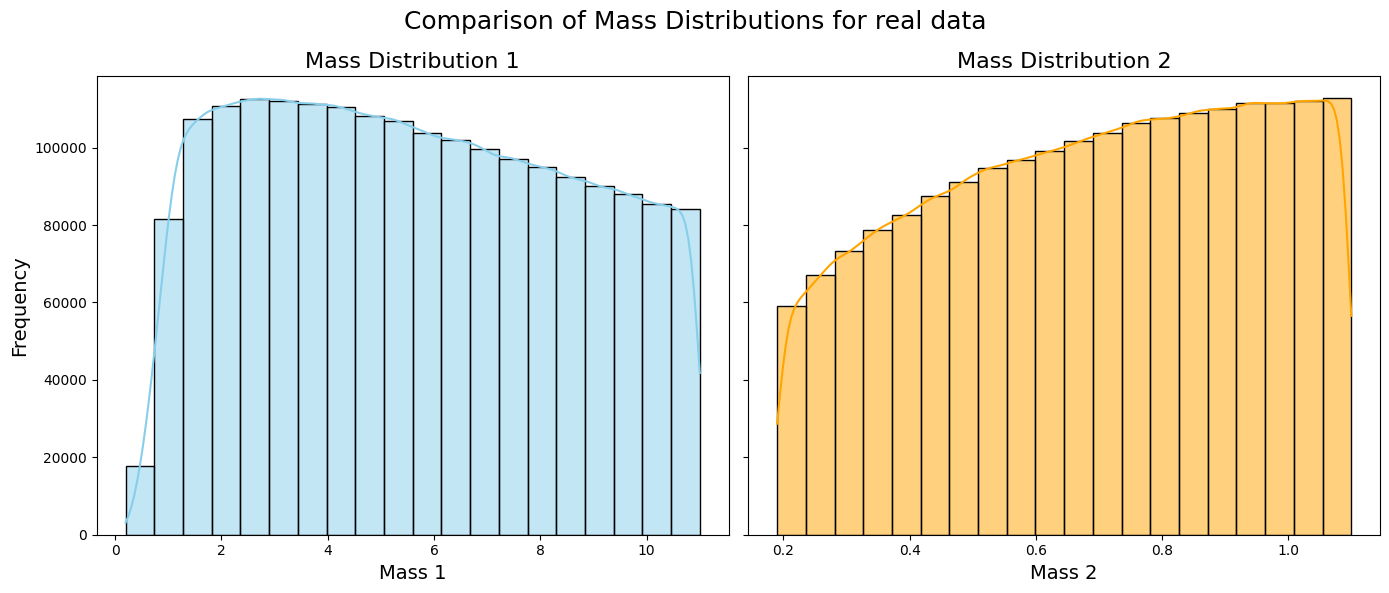

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Plot of the distribution of 'mass1'
sns.histplot(df_true['mass1'], bins=20, kde=True, color='skyblue', ax=axs[0])
axs[0].set_xlabel('Mass 1', fontsize=14)
axs[0].set_ylabel('Frequency', fontsize=14)
axs[0].set_title('Mass Distribution 1', fontsize=16)

# Plot of the distribution of 'mass2'
sns.histplot(df_true['mass2'], bins=20, kde=True, color='orange', ax=axs[1])
axs[1].set_xlabel('Mass 2', fontsize=14)
axs[1].set_title('Mass Distribution 2', fontsize=16)

fig.suptitle('Comparison of Mass Distributions for real data', fontsize=18)

# Adjust the layout and display the chart
plt.tight_layout()
plt.show()

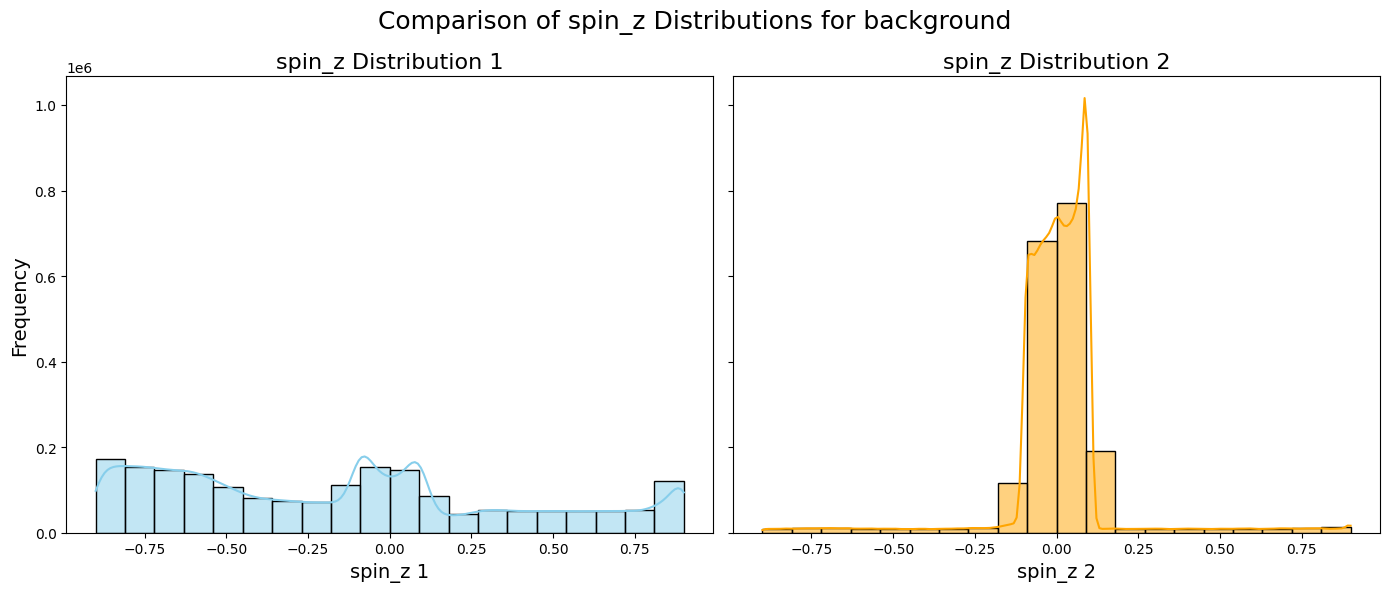

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Plot of the distribution of 'spin1z'
sns.histplot(df_false['spin1z'], bins=20, kde=True, color='skyblue', ax=axs[0])
axs[0].set_xlabel('spin_z 1', fontsize=14)
axs[0].set_ylabel('Frequency', fontsize=14)
axs[0].set_title('spin_z Distribution 1', fontsize=16)

# Plot of the distribution of 'spin2z'
sns.histplot(df_false['spin2z'], bins=20, kde=True, color='orange', ax=axs[1])
axs[1].set_xlabel('spin_z 2', fontsize=14)
axs[1].set_title('spin_z Distribution 2', fontsize=16)

fig.suptitle('Comparison of spin_z Distributions for background', fontsize=18)

# Adjust the layout and display the chart
plt.tight_layout()
plt.show()

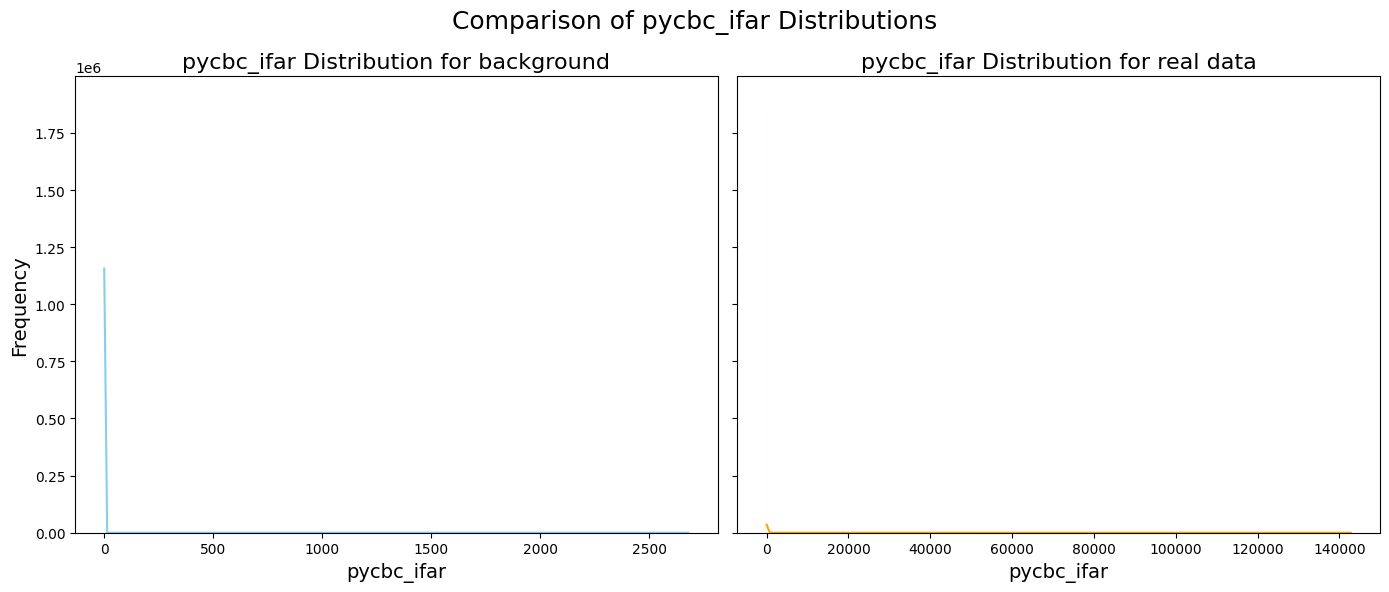

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Plot of the distribution of 'pycbc_ifar'
sns.histplot(df_false['pycbc_ifar'], bins=10000, kde=True, color='skyblue', ax=axs[0])
axs[0].set_xlabel('pycbc_ifar', fontsize=14)
axs[0].set_ylabel('Frequency', fontsize=14)
axs[0].set_title('pycbc_ifar Distribution for background', fontsize=16)

# Plot of the distribution of 'spin2z'
sns.histplot(df_true['pycbc_ifar'], bins=10000, kde=True, color='orange', ax=axs[1])
axs[1].set_xlabel('pycbc_ifar', fontsize=14)
axs[1].set_title('pycbc_ifar Distribution for real data', fontsize=16)

fig.suptitle('Comparison of pycbc_ifar Distributions', fontsize=18)

# Adjust the layout and display the chart
plt.tight_layout()
plt.show()

In [21]:
columns_greater_than_10 = (df_false['pycbc_ifar'] > 10).sum()
print(f"Number of columns in 'ifar_false' greater than 10: {columns_greater_than_10}")

Number of columns in 'ifar_false' greater than 10: 358


In [22]:
columns_greater_than_10 = (df_true['pycbc_ifar'] > 10).sum()
print(f"Number of columns in 'ifar_true' greater than 10: {columns_greater_than_10}")

Number of columns in 'ifar_true' greater than 10: 63312


In [23]:
df = pd.concat([df_true, df_false], axis=0)
df

,mass1,mass2,pycbc_ifar,spin1z,spin2z,label
0,1.692460,0.501600,0.000000,-0.037187,0.007150,1
1,6.421466,0.763863,0.000000,0.021298,0.038439,1
2,10.481894,1.045793,0.000000,0.012784,-0.030501,1
3,8.906005,0.811978,0.000000,-0.000504,-0.004068,1
4,7.129897,0.808812,0.000000,-0.001127,-0.003302,1
...,...,...,...,...,...,...
1916578,0.864843,0.247605,0.000010,-0.416889,0.025385,0
1916579,0.501223,0.202115,0.000011,-0.743296,-0.011618,0
1916580,0.956881,0.213006,0.000470,-0.813010,0.049815,0
1916581,0.808391,0.312963,0.000045,-0.449955,-0.030445,0


In [24]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

In [25]:
# Exploración de datos
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3833166 entries, 0 to 1916582
Data columns (total 6 columns):
 #   Column      Dtype  
---  ------      -----  
 0   mass1       float64
 1   mass2       float64
 2   pycbc_ifar  float64
 3   spin1z      float64
 4   spin2z      float64
 5   label       int64  
dtypes: float64(5), int64(1)
memory usage: 204.7 MB


In [26]:
df.describe()

,mass1,mass2,pycbc_ifar,spin1z,spin2z,label
count,3.833166e+06,3.833166e+06,3.833166e+06,3.833166e+06,3.833166e+06,3833166.0
mean,3.471293e+00,4.917871e-01,3.175995e+02,-7.708433e-02,3.945316e-03,0.5
std,3.106359e+00,2.840450e-01,3.890053e+03,3.816217e-01,1.290550e-01,0.5
min,1.958331e-01,1.900007e-01,0.000000e+00,-9.000000e-01,-8.999972e-01,0.0
25%,9.126695e-01,2.351717e-01,0.000000e+00,-1.657461e-01,-3.013016e-02,0.0
50%,2.096459e+00,3.842256e-01,1.548821e-06,-6.712440e-03,1.399800e-03,0.5
75%,5.674761e+00,7.272952e-01,4.354362e-05,3.252966e-02,3.906670e-02,1.0
max,1.099997e+01,1.100000e+00,1.427988e+05,9.000000e-01,8.999999e-01,1.0


In [27]:
# Definir las características (features) y el objetivo (label)
X = df.drop('label', axis=1)
y = df['label']

In [28]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
X_train

,mass1,mass2,pycbc_ifar,spin1z,spin2z
457198,1.913760,0.273239,0.000336,-0.034828,-0.011404
1504983,1.259362,0.270832,0.008402,0.631286,0.043176
1181923,4.821619,0.356829,0.000000,0.000097,0.001230
114185,1.273954,0.211858,0.000321,-0.737009,0.082421
191126,3.466504,0.873059,0.000000,0.006168,-0.019289
...,...,...,...,...,...
439747,1.258650,0.494431,0.000007,-0.898765,-0.099318
1594983,1.465865,0.230938,0.000012,-0.627842,0.012932
312501,0.947898,0.248354,0.000067,-0.394066,-0.004968
851724,0.205109,0.205109,0.000288,0.050495,-0.061751


In [30]:
#datos entrenamiento (deben ser 80%)
len(y_train)

3066532

In [31]:
y_train.value_counts()[0]

1533426

In [32]:
y_train.value_counts()[1]

1533106

In [33]:
#datos validación (deben ser 20%)
len(y_test)

766634

In [34]:
y_test.value_counts()[1]

383477

In [35]:
# Escalar los datos
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [41]:
%%time
# Definir y entrenar el modelo Random Forest
model = RandomForestClassifier()
model.fit(X_train, y_train)

CPU times: user 34min 27s, sys: 6.89 s, total: 34min 33s
Wall time: 36min 57s


RandomForestClassifier()

In [42]:
# Predecir sobre el conjunto de prueba
y_pred = model.predict(X_test)

In [43]:
# Calcular métricas de rendimiento
roc_auc = roc_auc_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

In [44]:
# Calcular el porcentaje de verdaderos positivos
total_test_samples = len(y_test)
tp_percentage_over_test = (tp / total_test_samples) * 100
tp_percentage_over_test_positive = (tp / y_test.value_counts()[1]) * 100

Results for Random Forest:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    383157
           1       1.00      1.00      1.00    383477

    accuracy                           1.00    766634
   macro avg       1.00      1.00      1.00    766634
weighted avg       1.00      1.00      1.00    766634

Confusion Matrix for Random Forest:
True Negatives: 382685
False Positives: 472
False Negatives: 991
True Positives: 382486
Number of True Positives in y_test: 383477
Percentage of True Positives over Test Set: 49.89%
Percentage of True Positives over Test Set Positives: 99.74%
ROC-AUC Score: 0.9980919400658674
Accuracy: 0.9980916578184635




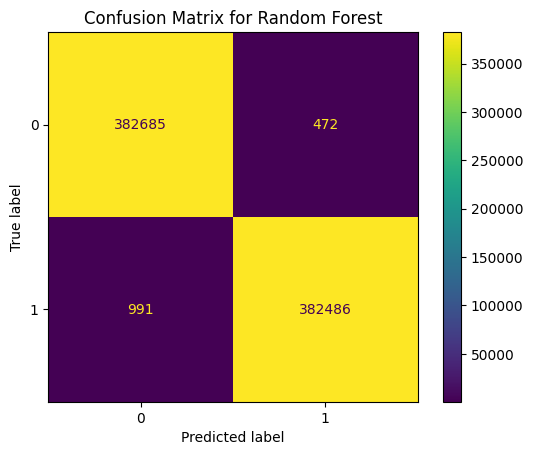

In [45]:
# Imprimir los resultados
print("Results for Random Forest:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix for Random Forest:")
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")
print(f"Number of True Positives in y_test: {y_test.value_counts()[1]}")
print(f"Percentage of True Positives over Test Set: {tp_percentage_over_test:.2f}%")
print(f"Percentage of True Positives over Test Set Positives: {tp_percentage_over_test_positive:.2f}%")
print(f"ROC-AUC Score: {roc_auc}")
print(f"Accuracy: {accuracy}")
print("\n")

# Mostrar la Matriz de Confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion Matrix for Random Forest')
plt.show()
